<a href="https://colab.research.google.com/github/dmed10/Water-Pump-Challenge/blob/main/Copy_of_LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 2, Module 3*

---
<p style="padding: 10px; border: 2px solid red;">
    <b>Before you start:</b> Today is the day you should submit the dataset for your Unit 2 Build Week project. You can review the guidelines and make your submission in the Build Week course for your cohort on Canvas.</p>

In [ ]:
%%capture
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Hyperparameter Tuning

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Establish the baseline accuracy score for your dataset.
- **Task 4:** Build `clf_dt`.
- **Task 5:** Build `clf_rf`.
- **Task 6:** Evaluate classifiers using k-fold cross-validation.
- **Task 7:** Tune hyperparameters for best performing classifier.
- **Task 8:** Print out best score and params for model.
- **Task 9:** Create `submission.csv` and upload to Kaggle.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/MyDrive/MyDrive/Kaggle'

In [ ]:
%cd /content/MyDrive/MyDrive/Kaggle

/content/MyDrive/MyDrive/Kaggle


In [ ]:
!kaggle competitions download -c ds34-water-pump-challenge

401 - Unauthorized


In [ ]:
# !unzip \*.zip  && rm *.zip

In [ ]:
!ls

kaggle.json	    sample_submission.csv  train_features.csv
new_submission.csv  test_features.csv	   train_labels.csv


In [ ]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, 
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')
    
  # Turn my boolean column to a binary one
  df['permit'] = df['permit'] * 1
    
  # Hot encode my column
  pd.get_dummies(df['quantity'], prefix='quantity')
  df = pd.concat([df, pd.get_dummies(df['quantity'], prefix='quantity')], axis= 1)

  # pd.get_dummies(df['source_class'], prefix='source_class')
  # df = pd.concat([df, pd.get_dummies(df['source_class'], prefix='source_class')], axis=1)

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Dropping more columns
  df.drop(columns=['num_private'], inplace=True)
  df.drop(columns=['waterpoint_type_group'], inplace=True)
  df.drop(columns=['public_meeting'], inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns
  dupe_cols = [col for col in df.head(100).T.duplicated().index # change 15 to 100!!!!
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)             

  return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')
X_test = wrangle(fm_path='test_features.csv')

In [ ]:
df.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,status_group,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,Water Board,1,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,functional,0,0,1,0,0,15.0
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,VWC,1,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,functional,0,1,0,0,0,NaN
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,VWC,0,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,non functional,0,1,0,0,0,NaN
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,VWC,1,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,non functional,0,0,1,0,0,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,VWC,1,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,non functional,0,1,0,0,0,14.0


In [ ]:
df.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'region',
       'region_code', 'district_code', 'population', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'status_group', 'quantity_dry', 'quantity_enough',
       'quantity_insufficient', 'quantity_seasonal', 'quantity_unknown',
       'pump_age'],
      dtype='object')

In [ ]:
X_test.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'region',
       'region_code', 'district_code', 'population', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'quantity_dry', 'quantity_enough',
       'quantity_insufficient', 'quantity_seasonal', 'quantity_unknown',
       'pump_age'],
      dtype='object')

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [ ]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

# III. Establish Baseline

**Task 3:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
y.value_counts(normalize=True)

functional                 0.542983
non functional             0.384078
functional needs repair    0.072939
Name: status_group, dtype: float64

In [ ]:
baseline_acc = y.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5429828068772491


# IV. Build Models

**Task 4:** Build a `Pipeline` named `clf_dt`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` Predictor.

**Note:** Do not train `clf_dt`. You'll do that in a subsequent task. 

In [ ]:
clf_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
);

**Task 5:** Build a `Pipeline` named `clf_rf`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Do not train `clf_rf`. You'll do that in a subsequent task. 

In [ ]:
clf_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs= -1)
);

# V. Check Metrics

**Task 6:** Evaluate the performance of both of your classifiers using k-fold cross-validation.

In [ ]:
cv_scores_dt = cross_val_score(clf_dt, X, y, cv=5, n_jobs=-1)
cv_scores_rf = cross_val_score(clf_rf, X, y, cv=5, n_jobs=-1)

In [ ]:
print('CV scores DecisionTreeClassifier')
print(cv_scores_dt)
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV scores DecisionTreeClassifier
[0.74431818 0.74715909 0.74358165 0.75242003 0.74702725]
Mean CV accuracy score: 0.7469012421560302
STD CV accuracy score: 0.0031058434856662265


In [ ]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.79924242 0.79861111 0.79850589 0.80281987 0.79701147]
Mean CV accuracy score: 0.7992381525982758
STD CV accuracy score: 0.0019347447180218455


# VI. Tune Model

**Task 7:** Choose the best performing of your two models and tune its hyperparameters using a `RandomizedSearchCV` named `model`. Make sure that you include cross-validation and that `n_iter` is set to at least `25`.

**Note:** If you're not sure which hyperparameters to tune, check the notes from today's guided project and the `sklearn` documentation. 

In [ ]:
param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5,50,5),
    'randomforestclassifier__n_estimators': range(25,150,25),
}

model = RandomizedSearchCV(
    clf_rf,
    param_distributions = param_grid,
    n_jobs = -1,
    cv = 5,
    verbose = 1,
    n_iter = 50
)

model.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 50, 5),
                                        'randomforestclassifier__n_estimators': range(25, 150, 25),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

**Task 8:** Print out the best score and best params for `model`.

In [ ]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.805130499282346
Best params for `model`: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 125, 'randomforestclassifier__max_depth': 20}


# Communicate Results

**Task 9:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site. 

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting. 

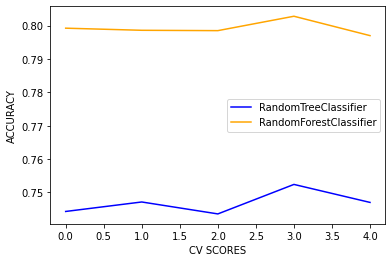

In [ ]:
plt.plot(cv_scores_dt, color='blue', label='RandomTreeClassifier')
plt.plot(cv_scores_rf, color='orange', label='RandomForestClassifier')
plt.xlabel('CV SCORES')
plt.ylabel('ACCURACY')
plt.legend()
plt.show()

In [ ]:
submission = pd.DataFrame(data=model.predict(X_test), index=X_test.index)

In [ ]:
X_test.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,NaN,NaN,31.985658,-3.596360,Lake Tanganyika,Shinyanga,17,5.0,NaN,WUG,1,NaN,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,1,0,0,0,0,NaN
14530,NaN,NaN,32.832815,-4.944937,Lake Tanganyika,Tabora,14,6.0,NaN,VWC,1,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump,0,0,1,0,0,NaN
62607,10.0,1675.0,35.488289,-4.242048,Internal,Manyara,21,1.0,148.0,Water Board,1,2008.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,0,0,1,0,0,5.0
46053,NaN,NaN,33.140828,-9.059386,Lake Rukwa,Mbeya,12,6.0,NaN,VWC,0,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,0,0,0,1,0,NaN
47083,50.0,1109.0,34.217077,-4.430529,Internal,Singida,13,1.0,235.0,WUA,1,2011.0,mono,mono,motorpump,wua,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,0,1,0,0,0,2.0


In [ ]:
df.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,status_group,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,Water Board,1,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,functional,0,0,1,0,0,15.0
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,VWC,1,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,functional,0,1,0,0,0,NaN
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,VWC,0,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,non functional,0,1,0,0,0,NaN
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,VWC,1,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,non functional,0,0,1,0,0,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,VWC,1,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,non functional,0,1,0,0,0,14.0


In [ ]:
submission

,0
id,
37098,non functional
14530,functional
62607,functional
46053,non functional
47083,functional
...,...
26092,functional
919,functional
47444,non functional


In [ ]:
submission.columns = ['status_group']

In [ ]:
submission

,status_group
id,
37098,non functional
14530,functional
62607,functional
46053,non functional
47083,functional
...,...
26092,functional
919,functional
47444,non functional


In [ ]:
submission.to_csv('new_submission.csv')

In [ ]:
from google.colab import files
files.download('new_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>